In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.api import OLS, WLS, GLS, RecursiveLS, GLSAR, RLM
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
import random

In [3]:
class Dataset:
    def __init__(self, scale, dimensions, num_points, coefficients, X, y):
        self.scale = scale
        self.noise_scale = 0.1
        self.dimensions = dimensions
        self.num_points = num_points
        self.coefficients = coefficients
        self.X = X
        self.y = y
        
    @staticmethod
    def generate(scale, dimensions, num_points) -> 'Dataset':
        coefficients = np.random.normal(scale=scale, size = dimensions)
        def myline(X):
            return (coefficients * X).sum()
        
        X = np.random.uniform(low=-scale/2, high=scale/2, size=(num_points, dimensions))
        y = np.apply_along_axis(myline, 1, X)
        return Dataset(scale, dimensions, num_points, coefficients, X, y)
    
    def generate_noise(self) -> 'Dataset':
        xp = self.X + np.random.normal(scale=self.scale*self.noise_scale, size=self.X.shape)
        yp = self.y + np.random.normal(scale=self.scale*self.noise_scale, size=self.y.shape)
        ds = Dataset(self.scale, self.dimensions, self.num_points, self.coefficients, xp, yp)
        ds.noise_scale = self.noise_scale
        return ds
    
    def truncate(self, size) -> 'Dataset':
        return Dataset(self.scale, self.dimensions, size, self.coefficients, self.X[:size], self.y[:size])

In [4]:
def run_iteration(model, dataset):
    if isinstance(model, type):
        m = model(dataset.y, dataset.X)
    else:
        m = model
    start = time.monotonic()
    if isinstance(model, type):
        results = m.fit()
    else:
        results = m.fit(dataset.X, dataset.y)
    end = time.monotonic()
    runtime = end - start
    
    if isinstance(model, type):
        error = np.linalg.norm((results.params - dataset.coefficients)/dataset.coefficients)
    else:
        error = np.linalg.norm((np.array(list(results.coef_)) - dataset.coefficients)/dataset.coefficients)
        
    return runtime, error
    
NUM_ITERATIONS = 10
    
def measure_iterations(model, dataset):
    runtimes = np.zeros(NUM_ITERATIONS)
    errors = np.zeros(NUM_ITERATIONS)
    for i in range(NUM_ITERATIONS):
        dataset_prime = dataset.generate_noise()
        runtime, error = run_iteration(model, dataset_prime)
        runtimes[i] = runtime
        errors[i] = error
        
    return runtimes.sum() / NUM_ITERATIONS, errors.sum() / NUM_ITERATIONS

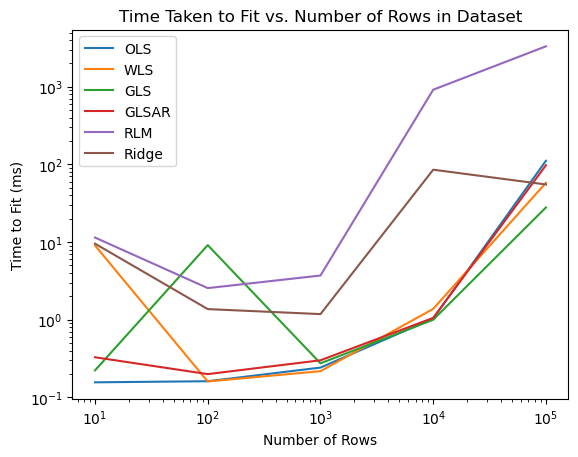

In [20]:
dataset = Dataset.generate(100, 4, 1000000)

models = [
    OLS,
    WLS,
    GLS, 
    GLSAR, 
    # RollingOLS(y, X)
    RLM,
    Ridge()
]
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Time to Fit (ms)")
plt.title("Time Taken to Fit vs. Number of Rows in Dataset")

for model in models:
    runtimes, errors = [], []
    for i in range(1, 6):
        size = 10**i
        dataset_prime = dataset.truncate(size)
        runtime, error = measure_iterations(model, dataset_prime)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([10**i for i in range(1, 6)], runtimes, label=getattr(model, "__name__", model.__class__.__name__))
    
plt.legend(loc='upper left')
plt.show() 

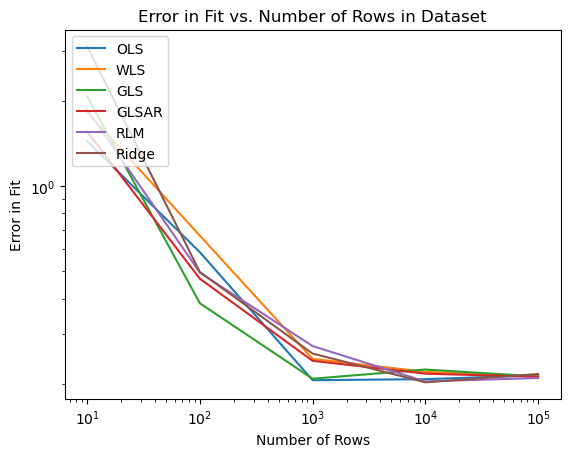

In [21]:
models = [
    OLS,
    WLS,
    GLS, 
    GLSAR, 
    # Ridge(),
    RLM,
    # RollingOLS(y, X)
    Ridge()
]

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Error in Fit")
plt.title("Error in Fit vs. Number of Rows in Dataset")

for model in models:
    runtimes, errors = [], []
    for i in range(1, 6):
        size = 10**i
        dataset_prime = dataset.truncate(size)
        runtime, error = measure_iterations(model, dataset_prime)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([10**i for i in range(1, 6)], errors, label=getattr(model, "__name__", model.__class__.__name__))

plt.legend(loc='upper left')
plt.show() 

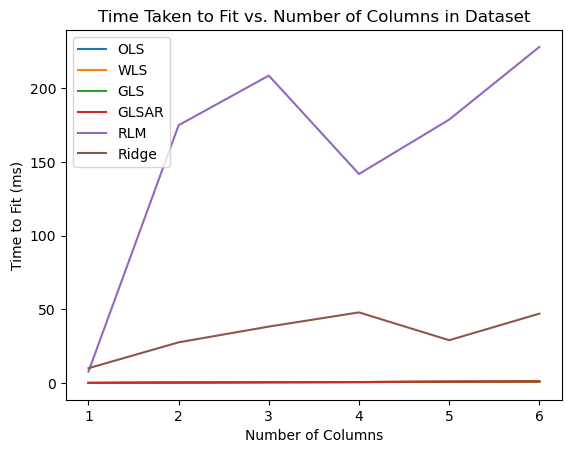

In [8]:
models = [
    OLS,
    WLS,
    GLS, 
    GLSAR, 
    RLM,
    Ridge(),
]

plt.xlabel("Number of Columns")
plt.ylabel("Time to Fit (ms)")
plt.title("Time Taken to Fit vs. Number of Columns in Dataset")

datasets = [Dataset.generate(100, i, 10000) for i in range(1, 7)]
for model in models:
    runtimes, errors = [], []
    for i in range(1, 7):
        dataset_prime = datasets[i - 1]
        runtime, error = measure_iterations(model, dataset_prime)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([i for i in range(1, 7)], runtimes, label=getattr(model, "__name__", model.__class__.__name__))
    
plt.legend(loc='upper left')
plt.show() 

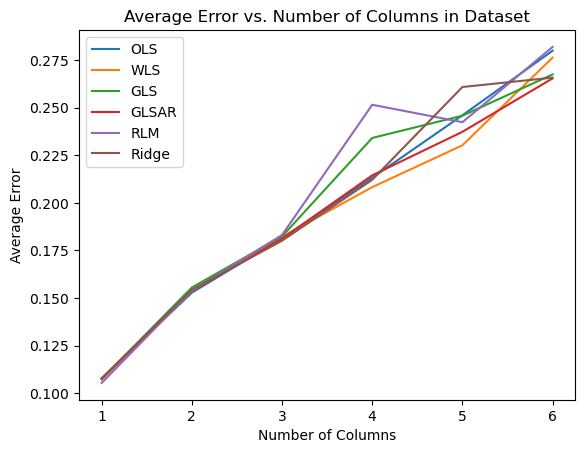

In [7]:
models = [
    OLS,
    WLS,
    GLS, 
    GLSAR, 
    RLM,
    Ridge(),
]

plt.xlabel("Number of Columns")
plt.ylabel("Average Error")
plt.title("Average Error vs. Number of Columns in Dataset")

for model in models:
    runtimes, errors = [], []
    for i in range(1, 7):
        dataset_prime = datasets[i - 1]
        runtime, error = measure_iterations(model, dataset_prime)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([i for i in range(1, 7)], errors, label=getattr(model, "__name__", model.__class__.__name__))
    
plt.legend(loc='upper left')
plt.show()

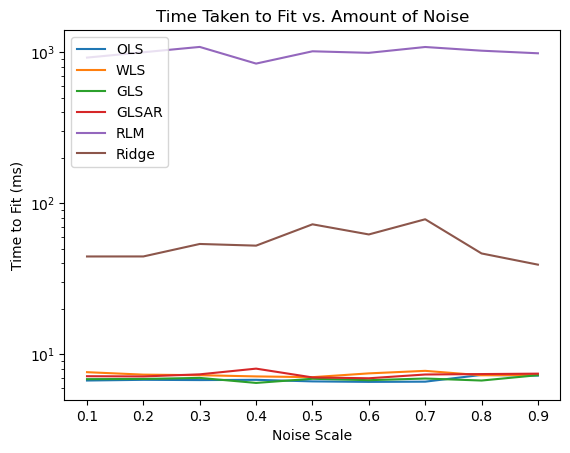

In [19]:
models = [
    OLS,
    WLS,
    GLS, 
    GLSAR, 
    RLM,
    # RollingOLS(y, X)
    Ridge()
]

dataset = Dataset.generate(100, 3, 100000)

plt.yscale('log')
plt.xlabel("Noise Scale")
plt.ylabel("Time to Fit (ms)")
plt.title("Time Taken to Fit vs. Amount of Noise")

for model in models:
    runtimes, errors = [], []
    for i in range(1, 10):
        dataset.noise_scale = i/10
        runtime, error = measure_iterations(model, dataset)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([i/10 for i in range(1, 10)], runtimes, label=getattr(model, "__name__", model.__class__.__name__))
    
plt.legend(loc='upper left')
plt.show()

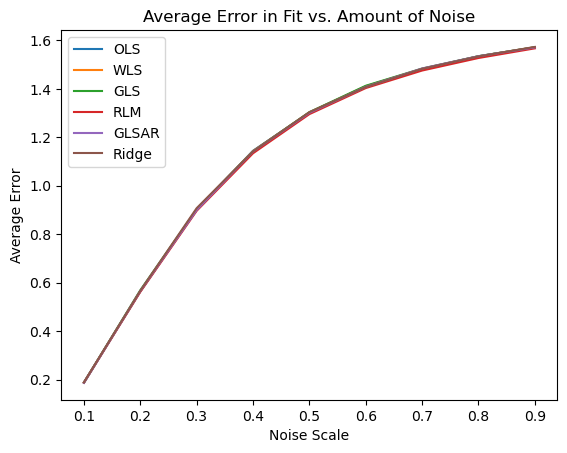

In [18]:
models = [
    OLS,
    WLS,
    GLS, 
    RLM,
    GLSAR, 
    # RollingOLS(y, X)
    Ridge()
]


plt.xlabel("Noise Scale")
plt.ylabel("Average Error")
plt.title("Average Error in Fit vs. Amount of Noise")

for model in models:
    runtimes, errors = [], []
    for i in range(1, 10):
        dataset.noise_scale = i/10
        runtime, error = measure_iterations(model, dataset)
        errors.append(error)
        runtimes.append(runtime * 1000)

    plt.plot([i/10 for i in range(1, 10)], errors, label=getattr(model, "__name__", model.__class__.__name__))

plt.legend(loc='upper left')
plt.show()